# **MDP를 모를 때 밸류 평가하기**

지금까지 MDP에서 보상함수 $r^a_s$와 상태 전이확률 $P^a_{ss'}$를 알 때를 기준으로 최적의 정책을 탐색하였음

이제 $r^a_s$와 $P^a_{ss'}$를 모름. 즉, 실제 action을 하기 전에는 특정 상태나 행동을 했을 때 어떤 보상을 얻는지, 어떤 상태로 이동하게 되는지 확률 분포 자체를 모르는 상황 -> Model-Free

## **2. Temporal Difference 학습**

### **1) 개요**

**접근법: 에피소드가 끝나기 전에 업데이트 할 수 없을까? → 미래의 추측으로 과거의 추측을 업데이트하자(=Temporal Difference)**

- 금요일: 상황을 보니 일요일에 비가 올 확률은 50%정도 되겠구나

- 토요일: 음, 상황을 **조금 더** 지켜보니 일요일에 비가 올 확률은 80%정도 되겠구나

- 일요일: 비가 옴

**MC라면?** -> 아, 일요일에 비가 왔네? 금요일의 예측값을 비가 올 확률이 더 높아지게 업데이트. 즉, 에피소드가 1번이라도 끝나야 과거의 예측을 업데이트할 수 있음

**TD라면?** -> 아, 일요일에 비가 왔네?까지 가지 않고 토요일의 예측값을 금요일의 예측값에 섞이도록 업데이트. 즉, 에피소드가 끝나지 않고 한 개의 step이 끝나면 과거(t-1)의 예측을 업데이트할 수 있음

**MC의 이론적 근거**
$$ v_\pi(s_t) = E_\pi[G_t] $$
t시점에 특정 state에서의 가치함수는 해당 시점 기준으로 얻은 + 미래에 얻을 수 있는 보상 합계의 기댓값인데, $G_t$를 많이 모을수록 그 기댓값은 $v_\pi(s_t)$에 수렴하게 됨

**TD의 이론적 근거**
$$ v_\pi(s_t) = E_\pi[r_{t+1} + \gamma{v_{\pi}}(s_{t+1})]$$  t시점에 특정 state에서의 가치함수는 해당 시점 기준으로 얻은 보상과 바로 다음 state에서의 상태가치함수 합계의 기댓값이다.

*여기서 $r_{t+1}+\gamma{v_\pi}(s_{t+1})$는 우리가 추정해야하는 값이고, 이를 TD Target이라 부름


### **2) TD 학습 알고리즘(그리드 월드로 설명 108p ~ 111p)**

**보상**: ? / **상태전이확률**: ? / **정책**: 4방향, uniform random


#### **(1) 테이블 초기화 - MC와 동일** 
#### **(2) 경험쌓기 - MC와 동일**
#### **(3) 테이블 업데이트**
지나온 경로가 $s_0 -> s_1 -> s_2 -> s_3 -> s_7 -> s_6 -> s_{10} -> s_{11} ->$종료였을 때, 

**MC기준 업데이트 수식은** $V(s_t) ← V(s_t) + \alpha(G_t - V(s_t))$로 나타낼 수 있으며, $S_0$ ~ $S_{11}$까지 한 에피소드가 종료되어야 상태에 대한 값을 업데이트할 수 있음

그러나 **TD기준 업데이트 수식은** $G_t$에 $r_{t+1} + \gamma{v_\pi}(s_t+1)$를 대입하여 $V(s_t) ← V(s_t) + \alpha(r_{t+1} + \gamma{V(s_{t+1})} - V(s_t))$로 나타낼 수 있는데,

각각의 상태 전이가 일어나자마자 바로 테이블의 값을 업데이트할 수 있음


이를 단계별로 풀어보면
$$(r = -1, \alpha = 0.01, \gamma = 1.0)$$

$$V(s_0) ← V(s_0) + 0.01 * (-1 + V(s_1) - V(s_0))$$

$$V(s_1) ← V(s_1) + 0.01 * (-1 + V(s_2) - V(s_1))$$

$$ ... $$

$$V(s_{11}) ← V(s_{11}) + 0.01 * (-1 + V(s_{15}) - V(s_{11}))$$

이렇게 한 에피소드를 각 step별로 업데이트하고, 이를 반복하여 테이블의 값이 수렴할 때까지 업데이트 한다.

In [31]:
from ch5_TDLearning import GridWorld, Agent
import warnings
warnings.filterwarnings(action='ignore')

## env, Agent 클래스는 MC와 동일하므로 생략

## main함수

In [34]:
import pandas as pd
def main():
    #TD
    env = GridWorld()
    agent = Agent()
    data = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
    # 보상, 할인율, 업데이트 파라미터 정의
    gamma = 1.0
    reward = -1
    alpha = 0.01
    
    # 총 5만 번의 에피소드를 진행하는데, 
    for k in range(50000):
        done = False
        # 에이전트가 경험을 쌓는 과정. not done이 True이면(done이 False인게 True면) 아래 변수들을 만드는데, done = True이면 not done은 False이니까 멈춘다. 
        while not done:
            #x, y의 현재 좌표(state) 가져오기
            x, y = env.get_state()
            # action 선택하기
            action = agent.select_action()
            
            # (x',y')의 좌표, 보상, 중단여부 변수를 만들고(env에서 정의한 step 함수, is_done 함수 등에 의해 (self.x, self.y), reward, done 를 리턴)
            (x_prime, y_prime), reward, done = env.step(action)
#             print("x:{}, x_prime:{}, y:{}, y_prime:{}".format(x, x_prime, y, y_prime))
            
            x_prime, y_prime = env.get_state()
#             print("data[x_prime][y_prime]:" +str(data[x_prime][y_prime]))
            
            #한 번의 step이 진행되자 마자 바로 테이블의 데이터를 업데이트 한다. 𝑉(𝑠𝑡) ← 𝑉(𝑠𝑡) + 𝛼(𝑟𝑡+1 + 𝛾𝑉(𝑠𝑡+1) − 𝑉(𝑠𝑡))
            data[x][y] = data[x][y] + alpha*(reward+gamma*data[x_prime][y_prime]-data[x][y])    
#             print("data[x][y]:" +str(data[x][y])+"\n")
            
        #한 에피소드가 끝나면 환경 리셋
        env.reset()
        
#     print("업데이트 결과: ")           
    for row in data:
        # row 출력 - 굳이 for를 쓰는 건 그대로 print(data)하면 list로 나오니깐 보기 불편함
        # 여기서 row에 있는 값은 data[x][y] = data[x][y] + alpha*(cum_reward-data[x][y])를 통해 업데이트한 값
        print(row)

if __name__ == '__main__':
    main()

[-59.93409359280402, -58.248404269731594, -54.576366012893, -50.91846879111262]
[-58.18223949551134, -54.707932837647874, -48.570371169102735, -43.6596135871193]
[-54.69201689758902, -49.869650260711296, -40.35073781629131, -28.992744097413276]
[-52.63449104882145, -45.89198444061301, -29.698579118103943, 0]


In [33]:
import pandas as pd
def main():
    #TD
    env = GridWorld()
    agent = Agent()
    data = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
    # 보상, 할인율, 업데이트 파라미터 정의
    gamma = 1.0
    reward = -1
    alpha = 0.01
    
    # 총 5만 번의 에피소드를 진행하는데, 
    for k in range(1):
        done = False
        # 에이전트가 경험을 쌓는 과정. not done이 True이면(done이 False인게 True면) 아래 변수들을 만드는데, done = True이면 not done은 False이니까 멈춘다. 
        while not done:
            #x, y의 현재 좌표(state) 가져오기
            x, y = env.get_state()
            # action 선택하기
            action = agent.select_action()
            
            # (x',y')의 좌표, 보상, 중단여부 변수를 만들고(env에서 정의한 step 함수, is_done 함수 등에 의해 (self.x, self.y), reward, done 를 리턴)
            (x_prime, y_prime), reward, done = env.step(action)
            print("x:{}, x_prime:{}, y:{}, y_prime:{}".format(x, x_prime, y, y_prime))
            
            x_prime, y_prime = env.get_state()
            print("data[x_prime][y_prime]:" +str(data[x_prime][y_prime]))
            
            #한 번의 step이 진행되자 마자 바로 테이블의 데이터를 업데이트 한다. 𝑉(𝑠𝑡) ← 𝑉(𝑠𝑡) + 𝛼(𝑟𝑡+1 + 𝛾𝑉(𝑠𝑡+1) − 𝑉(𝑠𝑡))
            data[x][y] = data[x][y] + alpha*(reward+gamma*data[x_prime][y_prime]-data[x][y])    
            print("data[x][y]:" +str(data[x][y])+"\n")
            
        #한 에피소드가 끝나면 환경 리셋
        env.reset()
        
    print("업데이트 결과: ")           
    for row in data:
        # row 출력 - 굳이 for를 쓰는 건 그대로 print(data)하면 list로 나오니깐 보기 불편함
        # 여기서 row에 있는 값은 data[x][y] = data[x][y] + alpha*(cum_reward-data[x][y])를 통해 업데이트한 값
        print(row)

if __name__ == '__main__':
    main()
# data[x_prime][y_prime]에 값이 있다는 것은, 과거에 그 값을 지나가봤다는 말 = 𝑉(𝑠0) ← 𝑉(𝑠0) + 0.01 ∗ (−1 + 𝑉(𝑠1) − 𝑉(𝑠0)) = 이 식을 풀 수 있다는 말
# step1에서 x:0, x_prime:0, y:0, y_prime:0이고
# step2에서도 x:0, x_prime:0, y:0, y_prime:0인 경우
# step3에서 x:0, x_prime:1, y:0, y_prime:0인 경우



# step 1
# x:0, x_prime:0, y:0, y_prime:0
# data[x_prime][y_prime]:0
# 0 + 0.01(-1 + 0 - 0) = -0.01
# 0,0의 밸류를 -0.01로 업데이트
# data[x][y]:-0.01

# step 2
# x:0, x_prime:0, y:0, y_prime:0
# data[x_prime][y_prime]:-0.01
# -0.01 + 0.01(-1 + (-0.01) -(-0.01)) = -0.02
# 0,0의 밸류를 -0.02로 다시 업데이트
# data[x][y]:-0.02

# step 3
# x:0, x_prime:1, y:0, y_prime:0
# data[x_prime][y_prime]:0
# -0.03 + 0.01(-1 + 0 -(-0.03)) = -0.0397 -> 𝑉(𝑠1)를 모르니까 0으로 들어감
# 0,0의 밸류를 -0.02로 다시 업데이트
# data[x][y]:-0.0298

x:0, x_prime:0, y:0, y_prime:0
data[x_prime][y_prime]:0
data[x][y]:-0.01

x:0, x_prime:0, y:0, y_prime:0
data[x_prime][y_prime]:-0.01
data[x][y]:-0.02

x:0, x_prime:0, y:0, y_prime:0
data[x_prime][y_prime]:-0.02
data[x][y]:-0.03

x:0, x_prime:1, y:0, y_prime:0
data[x_prime][y_prime]:0
data[x][y]:-0.0397

x:1, x_prime:2, y:0, y_prime:0
data[x_prime][y_prime]:0
data[x][y]:-0.01

x:2, x_prime:1, y:0, y_prime:0
data[x_prime][y_prime]:-0.01
data[x][y]:-0.0101

x:1, x_prime:1, y:0, y_prime:0
data[x_prime][y_prime]:-0.01
data[x][y]:-0.02

x:1, x_prime:1, y:0, y_prime:1
data[x_prime][y_prime]:0
data[x][y]:-0.0298

x:1, x_prime:2, y:1, y_prime:1
data[x_prime][y_prime]:0
data[x][y]:-0.01

x:2, x_prime:3, y:1, y_prime:1
data[x_prime][y_prime]:0
data[x][y]:-0.01

x:3, x_prime:3, y:1, y_prime:2
data[x_prime][y_prime]:0
data[x][y]:-0.01

x:3, x_prime:2, y:2, y_prime:2
data[x_prime][y_prime]:0
data[x][y]:-0.01

x:2, x_prime:2, y:2, y_prime:1
data[x_prime][y_prime]:-0.01
data[x][y]:-0.0101

x:2, x_pri

## **3. MC VS TD**

MC와 TD를 어떤 면에서 우세한지 아래 세 가지 기준으로 판단

### 1) 학습 시점

- Episodic MDP - 에피소드의 **종료 상태**가 명확히 존재하는 MDP (바둑, 엔딩이 있는 게임)
- Non-Episodic MDP - 종료 상태 없이 하나의 에피소드가 무한히 이어지는 MDP (주식 포트폴리오 분

→ MC는 Episodic MDP에만 적용할 수 있음(에피소드가 끝나야 학습과 업데이트가 가능함)

→ TD는 에피소드 중간에서도 학습과 업데이트를 할 수 있음(epi, non-epi 모두 적용 가능)

**TD 우세!**

https://daeson.tistory.com/328

### 2) 편향성(구하고자 하는 값에 가까운가?)

**MC(가치함수)**
$ v_\pi(s_t) = E_\pi[G_t] $

**TD(벨만기대방정식)**
$ v_\pi(s_t) = E_\pi[r_{t+1} + \gamma{v_{\pi}}(s_t+1)]$

→ MC의 근간이 되는 가치함수는 편향되어있지 않음(불편추정량). 실제 학습을 통해 얻은 리턴을 여러 개 모아서 평균을 내는 방법론이므로 샘플이 많아질수록 **대수의 법칙(≠중심극한정리)**에 의해 실제 값에 수렴할 수밖에 없음.

→ 그러나 TD는 편향되어 있음. $v_{\pi}(s_{t+1}) ≠ V_{\pi}(s_{t+1})$ 

벨만기대방정식에서 $v_{\pi}(s_{t+1})$는 실젯값이므로 우리가 찾아야 할 실제 TD Target이며, 결국 찾아놓은 $V_{\pi}(s_{t+1})$를 계속 업데이트 하면서 활용하게된다. 그러나 이 $V_{\pi}(s_{t+1})$가 실제 Target에 다가갈 것이란 보장이 없다.

현재의 추측치를 다음 스텝의 추측치로 업데이트 해주는 방법론(실제 가치와는 차이가 있음)

**MC 우세!**


### 3) 분산(계산한 값이 서로 많이 떨어져있는가?)
→ MC는 에피소드 * 반복횟수를 끝내야 $G_t$를 알 수 있는데, 때때로 에피소드가 최소 경로로 끝날 수도 있고, 최대 경로로 끝날 수도 있기 때문에 리턴 값간의 분산이 크다고 할 수 있다.(분산이 크다 = 편차가 크다 = 변동성이 크다)

→ 반면 TD는 한 step만 진행하면 업데이트가 가능하므로 step당 변동성이 MC에 비해 낮을 수 밖에 없다. 

**TD 우세!(분산이 클수록 학습이 힘듦)**

분산이 클수록 학습이 힘들다는 것은 무슨 말일까요?

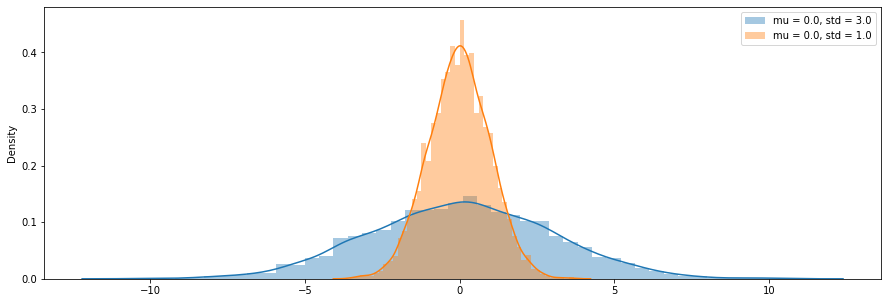

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,5))
mu, sigma = 0.0, 3.0
sns.distplot(np.random.normal(mu, sigma, size = 5000), label = "mu = {}, std = {}".format(mu, sigma))
mu, sigma = 0.0, 1.0
sns.distplot(np.random.normal(mu, sigma, size = 5000), label = "mu = {}, std = {}".format(mu, sigma))
plt.legend(loc = "best")
plt.show()

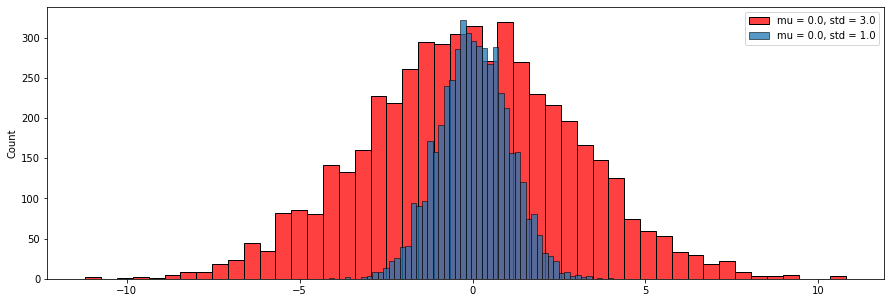

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,5))
mu, sigma = 0.0, 3.0
sns.histplot(np.random.normal(mu, sigma, size = 5000), label = "mu = {}, std = {}".format(mu, sigma), color = "r", )
mu, sigma = 0.0, 1.0
sns.histplot(np.random.normal(mu, sigma, size = 5000), label = "mu = {}, std = {}".format(mu, sigma))
plt.legend(loc = "best")
plt.show()